# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
# импорт библиотек
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split # разбивка выборки на обучающую и валидационную
from sklearn.metrics import mean_squared_error # средняя квадратичная ошибка (MSE)
# rmse = mse**0.5 - корень из средней квадратичной ошибки 
from sklearn.linear_model import LinearRegression # линейная регрессиия
from sklearn.feature_selection import SelectKBest # отбор лучших фичей
from sklearn.feature_selection import VarianceThreshold # удаление фичей с минимальной вариацией
from sklearn.impute import KNNImputer # заполнение пропусков метоом к ближайших соседей
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import RandomizedSearchCV # поиск оптимальных параметров
import time # измерение времени выполнения кода
from sklearn.preprocessing import StandardScaler # шкалирование

In [2]:
# убрать предупреждения
import warnings
warnings.filterwarnings("ignore")

In [3]:
# загрузка данных
# столбцы с данными в правильный формат


df = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'], index_col=['DateCrawled'])

In [4]:
# функция для описания df
def get_data_info(data):
    display(data.sample(5))
    display(data.info())
    display(data.describe(include='all'))

In [5]:
get_data_info(df)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
DateCrawled,,,,,,,,,,,,,,,
2016-03-12 12:50:35,5700,wagon,2002,manual,155,a4,125000,3,gasoline,audi,no,2016-03-12,0,91058,2016-03-16 13:45:14
2016-03-08 03:02:24,9700,sedan,2009,manual,122,golf,90000,1,petrol,volkswagen,no,2016-03-08,0,52428,2016-04-05 23:18:03
2016-04-02 21:38:29,590,small,1998,manual,0,arosa,150000,8,petrol,seat,NaN,2016-04-02,0,7551,2016-04-06 22:16:15
2016-03-31 00:37:03,11950,sedan,2008,manual,170,c_klasse,150000,5,gasoline,mercedes_benz,no,2016-03-31,0,64807,2016-04-06 01:16:42
2016-04-05 00:55:42,2550,bus,2006,manual,75,berlingo,150000,5,petrol,citroen,no,2016-04-05,0,47259,2016-04-05 08:45:01


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 354369 entries, 2016-03-24 11:52:17 to 2016-03-20 19:41:08
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Price              354369 non-null  int64         
 1   VehicleType        316879 non-null  object        
 2   RegistrationYear   354369 non-null  int64         
 3   Gearbox            334536 non-null  object        
 4   Power              354369 non-null  int64         
 5   Model              334664 non-null  object        
 6   Kilometer          354369 non-null  int64         
 7   RegistrationMonth  354369 non-null  int64         
 8   FuelType           321474 non-null  object        
 9   Brand              354369 non-null  object        
 10  Repaired           283215 non-null  object        
 11  DateCreated        354369 non-null  datetime64[ns]
 12  NumberOfPictures   354369 non-null  int64         
 13  PostalCode

None

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-03-10 00:00:00,NaN,NaN,2016-03-05 14:15:08
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-07 00:00:00,NaN,NaN,2016-04-07 14:58:51
mean,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN


In [6]:
# заголовки к нижнему регистру
df.columns = df.columns.str.lower() 

Пропуски:
- [] vehicletype кузов 
- [] gearbox коробка передач
- [] model модель автомобиля
- [] fueltype тип топлива
- [] repaired битая (больше всего здесь)
<br><br>
Пропусков нет по следующим количественным переменным, которые можно использовать для KNNImputer:<br><br>
- price цена (**но это target**)
- registrationyear год регистрации авто
- power
- kilometer пробег
- brand марка (но она категориальная, надо будет перекодировать - обучение перекодировщика может привести к утечки данных)
<br><br>
Не слишком полезные для предсказания цены переменные:<br><br>
- numberofpictures количество фотографий (там низкая вариация, как правило фотографий 0)
- postalcode почтовый индекс владельца это категориальная переменная на самом деле (в городах-дороже?)
- последний просмотр (можно сделать переменную - сколько дней висит объявление с момента скачивания базы? но для всех дата)

In [7]:
# numberofpictures удаляем, т.к. во всех объявлениях нет фотографий
# postalcode удаляем, т.к. это то же самое, что категориальная переменная закодированная
# LabelEncoding - для линейной модели не подходит
# registrationmonth - также неинформативная переменная, года достаточно

df = df.drop(['numberofpictures', 'postalcode', 'registrationmonth'], axis=1)

In [8]:
# разделим данные на обучающую и тестовую выборки не разделяя на фичи и таргет
# константа RANDOM_STATE 
RANDOM_STATE = 12345

# features = df.drop(['price'], axis=1)
# target = df['price']

df_train, df_test = train_test_split(df, test_size=0.25, random_state=RANDOM_STATE)

# работаем только с train, чтобы не было утечка данных


### Удаление аномалий на df_train

In [9]:
get_data_info(df_train)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired,datecreated,lastseen
DateCrawled,,,,,,,,,,,,
2016-03-27 13:50:02,1299,small,2002,manual,60,punto,80000,petrol,fiat,no,2016-03-27,2016-04-07 09:46:14
2016-03-30 20:36:23,15500,NaN,2005,auto,476,e_klasse,150000,NaN,mercedes_benz,no,2016-03-30,2016-04-01 16:44:35
2016-03-16 17:42:49,16750,small,2014,manual,90,a1,50000,gasoline,audi,no,2016-03-16,2016-04-02 22:21:54
2016-03-16 21:45:05,1350,NaN,2016,manual,0,seicento,60000,NaN,fiat,no,2016-03-16,2016-04-07 09:16:45
2016-03-05 22:40:09,3650,convertible,2004,manual,95,other,70000,petrol,ford,no,2016-03-05,2016-03-07 19:18:12


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265776 entries, 2016-03-17 18:37:00 to 2016-04-03 15:36:25
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   price             265776 non-null  int64         
 1   vehicletype       237696 non-null  object        
 2   registrationyear  265776 non-null  int64         
 3   gearbox           250916 non-null  object        
 4   power             265776 non-null  int64         
 5   model             251032 non-null  object        
 6   kilometer         265776 non-null  int64         
 7   fueltype          241133 non-null  object        
 8   brand             265776 non-null  object        
 9   repaired          212400 non-null  object        
 10  datecreated       265776 non-null  datetime64[ns]
 11  lastseen          265776 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(4), object(6)
memory usage: 26.4+ MB


None

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired,datecreated,lastseen
count,265776.000000,237696,265776.000000,250916,265776.000000,251032,265776.000000,241133,265776,212400,265776,265776
unique,NaN,8,NaN,2,NaN,250,NaN,7,40,2,105,145270
top,NaN,sedan,NaN,manual,NaN,golf,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 13:44:31
freq,NaN,68829,NaN,201214,NaN,21865,NaN,162307,57831,185347,10212,14
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-03-10 00:00:00,2016-03-05 14:15:08
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-07 00:00:00,2016-04-07 14:58:50
mean,4413.365319,NaN,2004.118923,NaN,110.205545,NaN,128223.409939,NaN,NaN,NaN,NaN,NaN
std,4511.068821,NaN,85.004061,NaN,195.100040,NaN,37888.556444,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,NaN,NaN,NaN,NaN,NaN
25%,1090.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,NaN,NaN,NaN,NaN,NaN


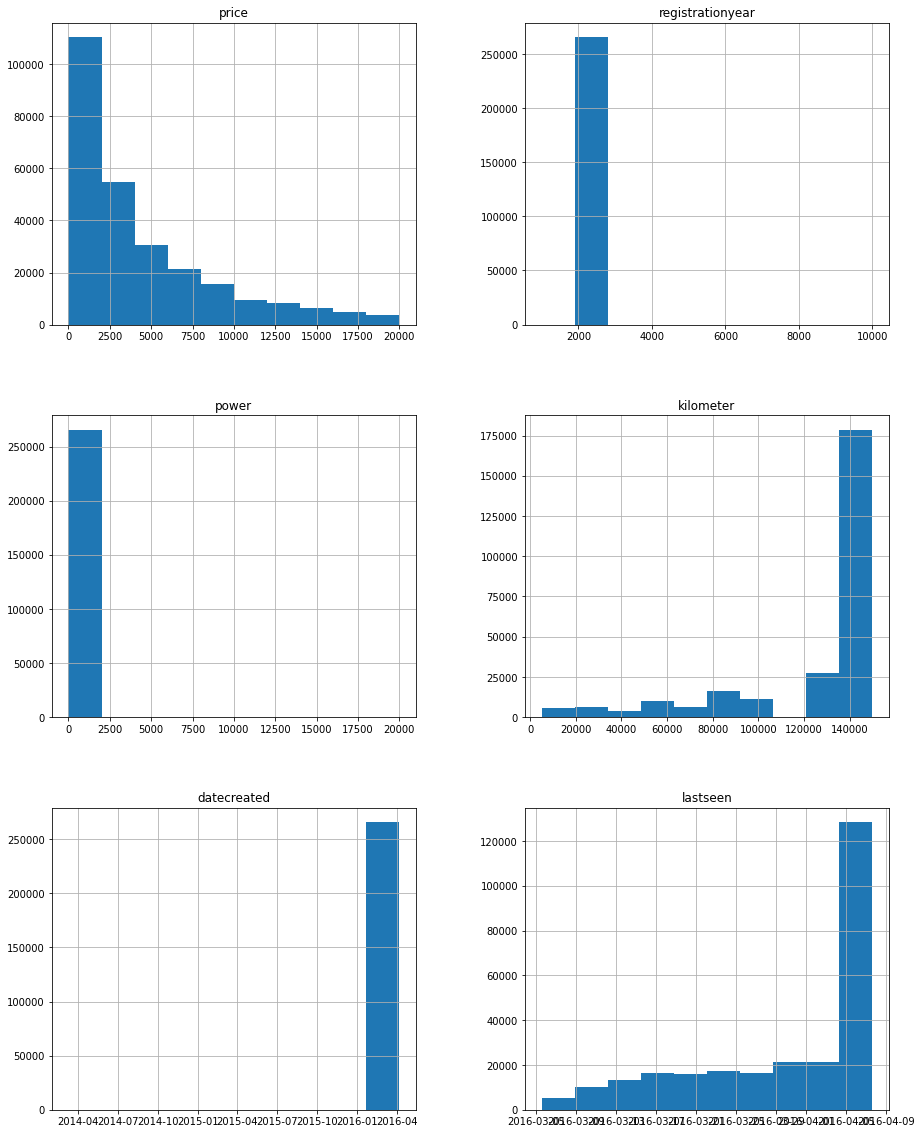

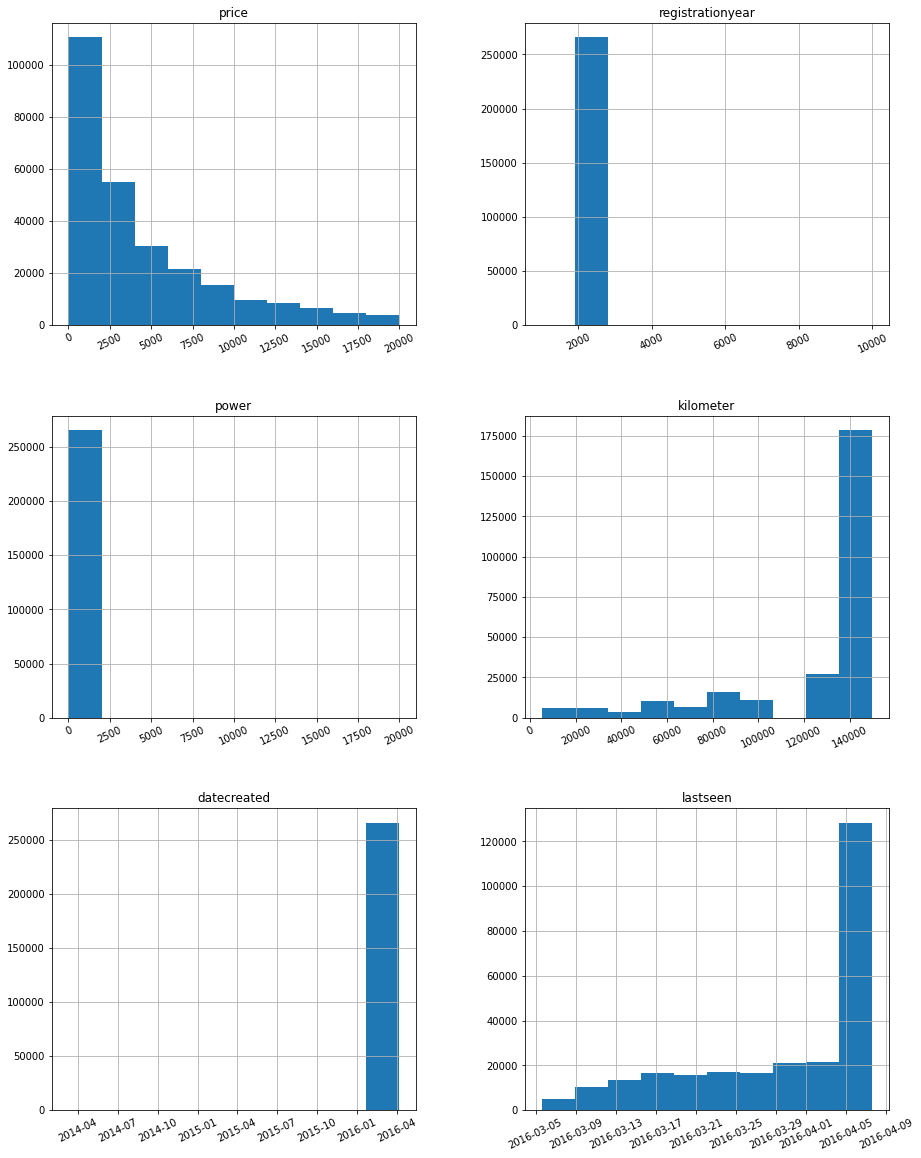

In [10]:
# посмотрим на гистограммы
df_train.hist(figsize=(15, 20));
# plt.xticks (Rotation = -15);
df_train.hist(figsize=(15, 20), xrot = 25);

Отрицательных значений нет. Аномалии по min и max есть во всех количественных переменных. Удалим аномалии. 

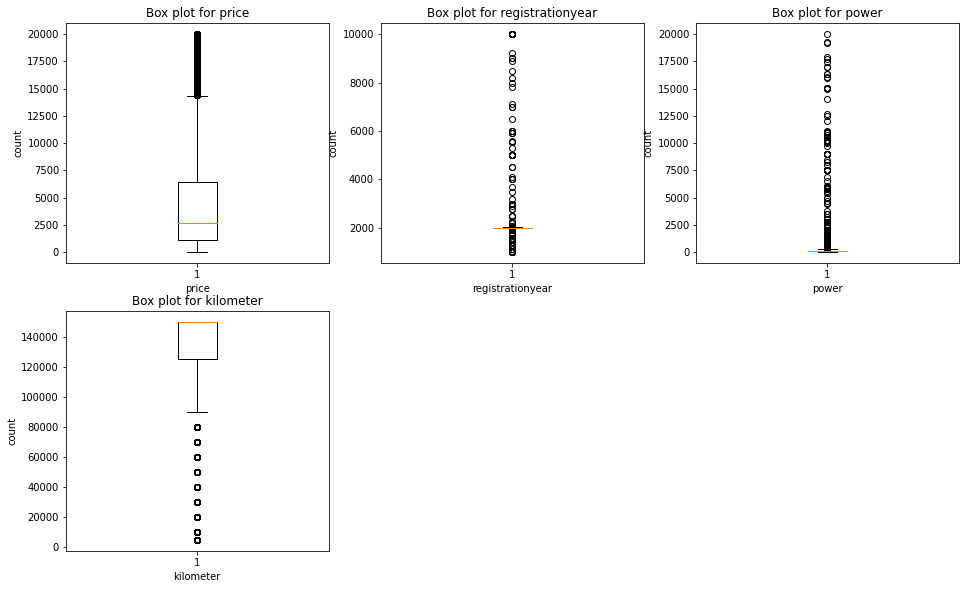

In [11]:
# цикл для проверки данных на выбросы: 
# построит для всех признаков формата int и float ящики с усами:

i = 1
plt.figure(figsize=(16,15))
for col_name in list(df_train.columns):
    if((df_train[col_name].dtypes=='int64' or df_train[col_name].dtypes=='float64') and col_name != 'charges'):
        plt.subplot(3,3, i)
        plt.boxplot(df_train[col_name])
        plt.xlabel(col_name)
        plt.ylabel('count')
        plt.title(f"Box plot for {col_name}")
        i += 1
plt.show()

In [12]:
# удаление аномалий через цикл и IQR

outliers_features = ['price', 'registrationyear', 'power']
for col_name in outliers_features:
    Q3 = df_train[col_name].quantile(0.75)
    Q1 = df_train[col_name].quantile(0.25)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5*IQR
    lower_limit = Q1 - 1.5*IQR
    prev_size = len(df_train)
    df_train = df_train[(df_train[col_name] >= lower_limit) & (df_train[col_name] <= upper_limit)]
    cur_size = len(df_train)
    print(f"удалили {prev_size - cur_size} строк в переменной {col_name}  с аномалиями")

удалили 14300 строк в переменной price  с аномалиями
удалили 4605 строк в переменной registrationyear  с аномалиями
удалили 4280 строк в переменной power  с аномалиями


In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 242591 entries, 2016-03-17 18:37:00 to 2016-04-03 15:36:25
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   price             242591 non-null  int64         
 1   vehicletype       216048 non-null  object        
 2   registrationyear  242591 non-null  int64         
 3   gearbox           228995 non-null  object        
 4   power             242591 non-null  int64         
 5   model             229596 non-null  object        
 6   kilometer         242591 non-null  int64         
 7   fueltype          219711 non-null  object        
 8   brand             242591 non-null  object        
 9   repaired          192589 non-null  object        
 10  datecreated       242591 non-null  datetime64[ns]
 11  lastseen          242591 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(4), object(6)
memory usage: 24.1+ MB


In [14]:
df_train.describe()

,price,registrationyear,power,kilometer
count,242591.000000,242591.000000,242591.000000,242591.000000
mean,3624.899996,2003.272409,99.850749,130711.691695
std,3407.647374,6.285462,54.792852,35712.219965
min,0.000000,1987.000000,0.000000,5000.000000
25%,999.000000,1999.000000,65.000000,125000.000000
50%,2450.000000,2003.000000,101.000000,150000.000000
75%,5390.000000,2007.000000,140.000000,150000.000000
max,14350.000000,2019.000000,248.000000,150000.000000


Нулевая и слишком маленькая цена и объем двигателя в лошадиных силах - это аномалии, их нужно удалить.

In [15]:
# удаляем нули
df_train = df_train[(df_train['price'] != 0)]
df_train = df_train[(df_train['power'] != 0)]

In [16]:
df_train.describe()

,price,registrationyear,power,kilometer
count,209420.000000,209420.000000,209420.000000,209420.000000
mean,3940.630670,2003.314793,113.099570,130894.756948
std,3445.464176,6.053246,43.654617,34553.721529
min,1.000000,1987.000000,1.000000,5000.000000
25%,1200.000000,1999.000000,75.000000,125000.000000
50%,2799.000000,2003.000000,106.000000,150000.000000
75%,5899.000000,2007.000000,140.000000,150000.000000
max,14350.000000,2019.000000,248.000000,150000.000000


Минимальный объем двигателя малолитражки за изучаемый период ок. 50 л.с.

In [17]:
df_train['power'].quantile(0.01)

45.0

<AxesSubplot:ylabel='Frequency'>

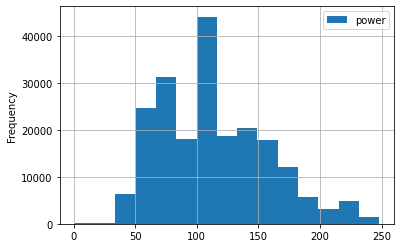

In [18]:
df_train.plot(kind='hist', y='power', bins=15, grid=True, legend=True)

In [19]:
df_train = df_train.loc[df_train['power'] >= 50]

<AxesSubplot:ylabel='Frequency'>

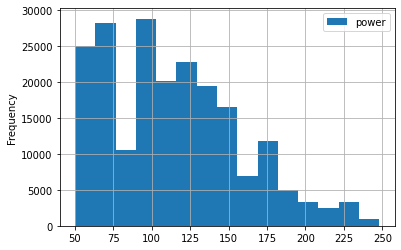

In [20]:
df_train.plot(kind='hist', y='power', bins=15, grid=True, legend=True)

In [21]:
df_train['price'].quantile(0.01)

150.0

<AxesSubplot:ylabel='Frequency'>

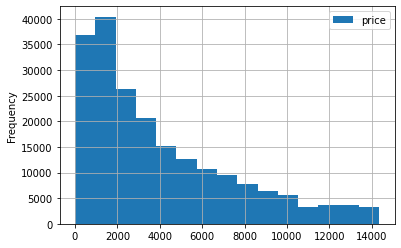

In [22]:
df_train.plot(kind='hist', y='price', bins=15, grid=True, legend=True)

In [23]:
df_train = df_train.loc[df_train['price'] >= 150]

<AxesSubplot:ylabel='Frequency'>

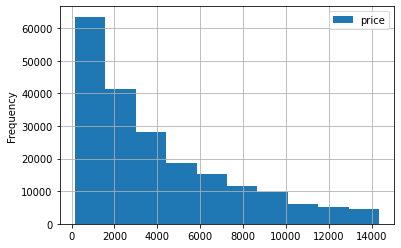

In [24]:
df_train.plot(kind='hist', y='price', bins=10, grid=True, legend=True)

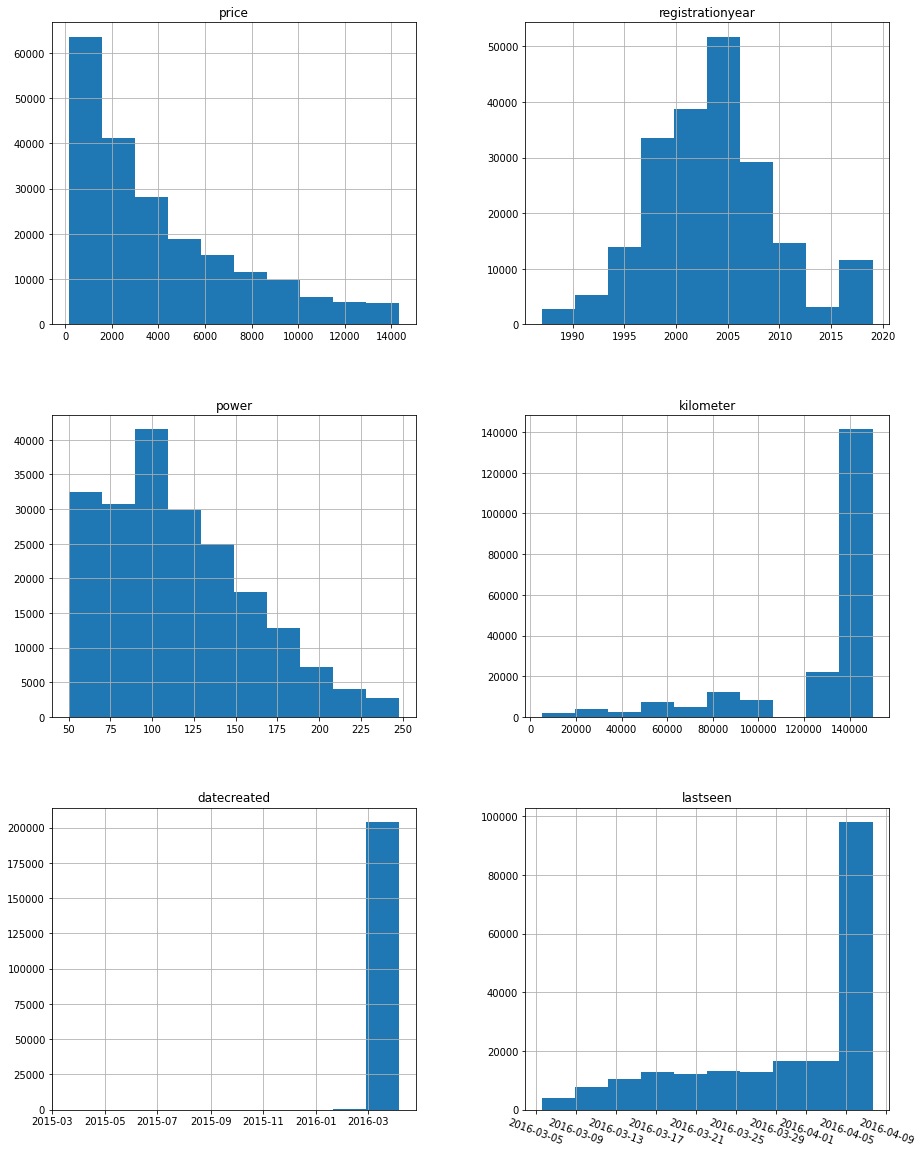

In [25]:
df_train.hist(figsize=(15, 20));
plt.xticks (Rotation = -20);

**Слишком долго зависшие на сайте объявления тоже аномалии**. (какие-то показатели не адекватны)<br><br>  
Рассчитать срок жизни объявления с адекватной ценой по разнице между датой публикации и датой последнего обращения к нему владельца

In [26]:
get_data_info(df_train)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired,datecreated,lastseen
DateCrawled,,,,,,,,,,,,
2016-04-04 10:55:26,650,NaN,1995,NaN,101,NaN,150000,petrol,bmw,no,2016-04-04,2016-04-04 10:55:26
2016-03-31 02:32:44,3299,wagon,2003,manual,101,astra,125000,gasoline,opel,no,2016-03-31,2016-04-05 17:26:12
2016-04-01 15:58:09,2700,sedan,2005,auto,150,vectra,150000,gasoline,opel,no,2016-04-01,2016-04-07 13:50:36
2016-03-23 18:45:47,9999,suv,2004,auto,177,range_rover,150000,gasoline,land_rover,no,2016-03-23,2016-04-03 22:18:01
2016-04-03 09:37:21,4990,bus,2009,manual,80,caddy,150000,petrol,volkswagen,no,2016-04-03,2016-04-07 11:17:19


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 204331 entries, 2016-03-17 18:37:00 to 2016-04-03 15:36:25
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   price             204331 non-null  int64         
 1   vehicletype       189745 non-null  object        
 2   registrationyear  204331 non-null  int64         
 3   gearbox           200414 non-null  object        
 4   power             204331 non-null  int64         
 5   model             196598 non-null  object        
 6   kilometer         204331 non-null  int64         
 7   fueltype          191039 non-null  object        
 8   brand             204331 non-null  object        
 9   repaired          172526 non-null  object        
 10  datecreated       204331 non-null  datetime64[ns]
 11  lastseen          204331 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(4), object(6)
memory usage: 20.3+ MB


None

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired,datecreated,lastseen
count,204331.000000,189745,204331.000000,200414,204331.000000,196598,204331.000000,191039,204331,172526,204331,204331
unique,NaN,8,NaN,2,NaN,245,NaN,7,40,2,99,119661
top,NaN,sedan,NaN,manual,NaN,golf,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-06 17:45:15
freq,NaN,55342,NaN,165724,NaN,17939,NaN,129061,45293,152246,7972,13
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-03-20 00:00:00,2016-03-05 14:15:08
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-07 00:00:00,2016-04-07 14:58:50
mean,4015.010096,NaN,2003.411612,NaN,114.553817,NaN,130999.676995,NaN,NaN,NaN,NaN,NaN
std,3447.185692,NaN,5.995702,NaN,42.903183,NaN,34368.254247,NaN,NaN,NaN,NaN,NaN
min,150.000000,NaN,1987.000000,NaN,50.000000,NaN,5000.000000,NaN,NaN,NaN,NaN,NaN
25%,1299.000000,NaN,1999.000000,NaN,75.000000,NaN,125000.000000,NaN,NaN,NaN,NaN,NaN


In [27]:
# вычли даты
df_train['time'] = (df_train['lastseen'] - df_train['datecreated']) / np.timedelta64 ( 1 , 'D')

In [28]:
# округлили
df_train['time'] = round(df_train['time'])

In [29]:
df_train.describe()

,price,registrationyear,power,kilometer,time
count,204331.000000,204331.000000,204331.000000,204331.000000,204331.000000
mean,4015.010096,2003.411612,114.553817,130999.676995,9.203743
std,3447.185692,5.995702,42.903183,34368.254247,8.470415
min,150.000000,1987.000000,50.000000,5000.000000,0.000000
25%,1299.000000,1999.000000,75.000000,125000.000000,3.000000
50%,2850.000000,2003.000000,109.000000,150000.000000,6.000000
75%,5950.000000,2007.000000,140.000000,150000.000000,14.000000
max,14350.000000,2019.000000,248.000000,150000.000000,384.000000


In [30]:
df_train['time'].quantile(0.99)

31.0

In [31]:
df_train = df_train.loc[df_train['time'] <= 35]

In [32]:
df_train.describe()

,price,registrationyear,power,kilometer,time
count,204118.000000,204118.000000,204118.000000,204118.000000,204118.000000
mean,4012.571424,2003.409753,114.541554,131011.522747,9.153637
std,3445.836506,5.995762,42.902480,34359.145288,8.240719
min,150.000000,1987.000000,50.000000,5000.000000,0.000000
25%,1299.000000,1999.000000,75.000000,125000.000000,3.000000
50%,2850.000000,2003.000000,109.000000,150000.000000,6.000000
75%,5950.000000,2007.000000,140.000000,150000.000000,14.000000
max,14350.000000,2019.000000,248.000000,150000.000000,35.000000


<AxesSubplot:ylabel='Frequency'>

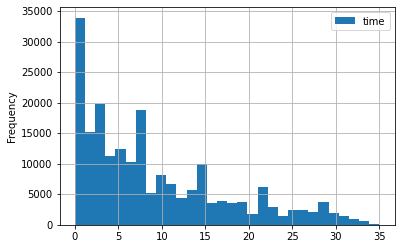

In [33]:
df_train.plot(kind='hist', y='time', bins=30, grid=True, legend=True)

Созданную переменную time, т.е. время, которое объявление висит на сайте, можно использовать для заполнения пропусков, но не для предсказания, т.к. для новых данных она не известна. 

### Заполнение пропусков df_train 

Заполним пропуски в категориальных переменных модой (в случае наличия) для для другой важной категориальной переменной.

In [34]:
# заполним пропуски в model модой для brand, если она есть, если нет unknown 

df_train['model'] = df_train['model'].fillna(df_train.groupby('brand')['model'].transform(
    lambda x:x.value_counts().idxmax() if x.count()!=0 else 'unknown')) 

In [35]:
# заполним пропуски в vehicletype модой для model, если она есть, если нет unknown

df_train['vehicletype'] = df_train['vehicletype'].fillna(df_train.groupby('model')['vehicletype'].transform(
    lambda x:x.value_counts().idxmax() if x.count()!=0 else 'unknown')) 

In [36]:
# заполним пропуски в gearbox модой для model, если она есть, если нет по умолчанию 'manual' (ручная)

df_train['gearbox'] = df_train['gearbox'].fillna(df_train.groupby('model')['gearbox'].transform(
    lambda x:x.value_counts().idxmax() if x.count()!=0 else 'manual'))

In [37]:
# заполним пропуски в fueltype модой для model, если она есть, если нет по умолчанию бензин 'petrol'

df_train['fueltype'] = df_train['fueltype'].fillna(df_train.groupby('model')['fueltype'].transform(
    lambda x:x.value_counts().idxmax() if x.count()!=0 else 'petrol'))

In [38]:
# заполним пропуски в repaired модой для model, если она есть, если нет по умолчанию 'no'

df_train['repaired'] = df_train['repaired'].fillna(df_train.groupby('model')['repaired'].transform(
    lambda x:x.value_counts().idxmax() if x.count()!=0 else 'no'))


In [39]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 204118 entries, 2016-03-17 18:37:00 to 2016-04-03 15:36:25
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   price             204118 non-null  int64         
 1   vehicletype       204118 non-null  object        
 2   registrationyear  204118 non-null  int64         
 3   gearbox           204118 non-null  object        
 4   power             204118 non-null  int64         
 5   model             204118 non-null  object        
 6   kilometer         204118 non-null  int64         
 7   fueltype          204118 non-null  object        
 8   brand             204118 non-null  object        
 9   repaired          204118 non-null  object        
 10  datecreated       204118 non-null  datetime64[ns]
 11  lastseen          204118 non-null  datetime64[ns]
 12  time              204118 non-null  float64       
dtypes: datetime64[ns](2), flo

In [40]:
get_data_info(df_train)

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired,datecreated,lastseen,time
DateCrawled,,,,,,,,,,,,,
2016-03-28 11:51:35,500,sedan,1996,auto,75,golf,125000,petrol,volkswagen,no,2016-03-28,2016-04-02 15:45:13,6.0
2016-03-12 12:36:22,6490,wagon,2009,manual,109,caddy,125000,cng,volkswagen,no,2016-03-12,2016-04-06 13:17:03,26.0
2016-03-23 08:55:33,8700,wagon,2010,auto,105,golf,150000,gasoline,volkswagen,no,2016-03-23,2016-03-23 09:39:15,0.0
2016-03-26 22:54:08,6200,wagon,2010,manual,110,laguna,150000,gasoline,renault,no,2016-03-26,2016-04-03 00:21:09,8.0
2016-03-12 14:58:17,5900,coupe,2003,manual,180,tt,150000,petrol,audi,no,2016-03-12,2016-04-07 01:17:36,26.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 204118 entries, 2016-03-17 18:37:00 to 2016-04-03 15:36:25
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   price             204118 non-null  int64         
 1   vehicletype       204118 non-null  object        
 2   registrationyear  204118 non-null  int64         
 3   gearbox           204118 non-null  object        
 4   power             204118 non-null  int64         
 5   model             204118 non-null  object        
 6   kilometer         204118 non-null  int64         
 7   fueltype          204118 non-null  object        
 8   brand             204118 non-null  object        
 9   repaired          204118 non-null  object        
 10  datecreated       204118 non-null  datetime64[ns]
 11  lastseen          204118 non-null  datetime64[ns]
 12  time              204118 non-null  float64       
dtypes: datetime64[ns](2), flo

None

,price,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired,datecreated,lastseen,time
count,204118.000000,204118,204118.000000,204118,204118.000000,204118,204118.000000,204118,204118,204118,204118,204118,204118.000000
unique,NaN,8,NaN,2,NaN,246,NaN,7,40,2,59,119582,NaN
top,NaN,sedan,NaN,manual,NaN,golf,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,2016-04-07 07:45:20,NaN
freq,NaN,62326,NaN,168948,NaN,19521,NaN,140033,45252,183844,7972,13,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-02-01 00:00:00,2016-03-05 14:15:08,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-04-07 00:00:00,2016-04-07 14:58:50,NaN
mean,4012.571424,NaN,2003.409753,NaN,114.541554,NaN,131011.522747,NaN,NaN,NaN,NaN,NaN,9.153637
std,3445.836506,NaN,5.995762,NaN,42.902480,NaN,34359.145288,NaN,NaN,NaN,NaN,NaN,8.240719
min,150.000000,NaN,1987.000000,NaN,50.000000,NaN,5000.000000,NaN,NaN,NaN,NaN,NaN,0.000000
25%,1299.000000,NaN,1999.000000,NaN,75.000000,NaN,125000.000000,NaN,NaN,NaN,NaN,NaN,3.000000


Пропусков не осталось. petrol это то же самое, что gasoline. Необходимо проверить неявные дубликаты в номинальных переменных. (надо было это делать до заполнения пропусков).

In [41]:
print(df_train['fueltype'].unique())

['petrol' 'gasoline' 'lpg' 'cng' 'hybrid' 'other' 'electric']


In [42]:
df_train['fueltype'] = df_train['fueltype'].replace('petrol', 'gasoline');

In [43]:
print(df_train['fueltype'].unique())

['gasoline' 'lpg' 'cng' 'hybrid' 'other' 'electric']


In [44]:
print(df_train['brand'].unique())

['ford' 'renault' 'opel' 'citroen' 'smart' 'fiat' 'seat' 'audi' 'honda'
 'volkswagen' 'chrysler' 'mini' 'mercedes_benz' 'bmw' 'mitsubishi' 'skoda'
 'alfa_romeo' 'mazda' 'peugeot' 'jaguar' 'toyota' 'sonstige_autos' 'kia'
 'daewoo' 'hyundai' 'lancia' 'dacia' 'nissan' 'volvo' 'suzuki' 'rover'
 'subaru' 'saab' 'daihatsu' 'chevrolet' 'land_rover' 'lada' 'jeep'
 'porsche' 'trabant']


In [45]:
print(df_train['gearbox'].unique())

['manual' 'auto']


In [46]:
print(df_train['vehicletype'].unique())

['sedan' 'small' 'wagon' 'coupe' 'bus' 'convertible' 'other' 'suv']


In [47]:
print(df_train['repaired'].unique())

['no' 'yes']


In [48]:
print(df_train['model'].unique())

['escort' 'twingo' 'astra' 'c4' 'fortwo' 'punto' 'leon' 'fiesta' 'a4'
 'civic' 'transporter' 'jazz' 'ibiza' 'ptcruiser' 'polo' 'fox' '80'
 'cooper' 'c_klasse' 'a6' 'other' 'golf' 'passat' '5er' 'octavia' '147'
 'vectra' 'ka' '3er' '6_reihe' '2_reihe' 'corsa' 'e_klasse' 'a_klasse'
 '1_reihe' 'bora' 'x_type' 'megane' 'clio' 'c3' 'b_klasse' 'clk' 'yaris'
 'unknown' 'mondeo' 'sharan' 'carnival' '3_reihe' 'caddy' 'matiz' 'colt'
 'focus' 'a3' 'scenic' 'touran' 'i_reihe' 'lybra' 'aygo' 'arosa' 'tt'
 'lupo' 'fabia' 'lancer' 'zafira' 'combo' 'galaxy' 'c1' 'meriva' 'sandero'
 'rx_reihe' 'rav' 'up' 'forfour' 'laguna' 'micra' 'c_max' 'a2' 'insignia'
 'omega' 'slk' 'beetle' 'seicento' 'agila' 'xc_reihe' 's_klasse' 'z_reihe'
 'note' 'spider' 'm_klasse' 'ducato' 'modus' 'scirocco' '1er' 'eos'
 'carisma' 'vito' 'tigra' 'swift' 'mii' 'altea' 'picanto' '7er' 'cordoba'
 'grand' 'viano' '500' 'justy' 'c5' 'primera' 'fusion' 'espace' 'mx_reihe'
 'citigo' 'avensis' 'jimny' 'doblo' 'c2' 'cuore' 'one' 'almera

In [49]:
print('объявлений, для которых модель неизветсна',  df_train.query('model == "unknown"').shape[0])

объявлений, для которых модель неизветсна 633


Есть еще 'other' в модели. Можно объединить c 'unknown', искуственно созданным при заполнении пропусков.  

In [50]:
df_train['model'] = df_train['model'].replace('unknown', 'other')

Проверим на дубликаты

In [51]:
df_train.duplicated().sum()

57

In [52]:
# удалим дубликаты 
df_train = df_train.drop_duplicates()
df_train.duplicated().sum()

0

In [53]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 204061 entries, 2016-03-17 18:37:00 to 2016-04-03 15:36:25
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   price             204061 non-null  int64         
 1   vehicletype       204061 non-null  object        
 2   registrationyear  204061 non-null  int64         
 3   gearbox           204061 non-null  object        
 4   power             204061 non-null  int64         
 5   model             204061 non-null  object        
 6   kilometer         204061 non-null  int64         
 7   fueltype          204061 non-null  object        
 8   brand             204061 non-null  object        
 9   repaired          204061 non-null  object        
 10  datecreated       204061 non-null  datetime64[ns]
 11  lastseen          204061 non-null  datetime64[ns]
 12  time              204061 non-null  float64       
dtypes: datetime64[ns](2), flo

Последняя дата просмотра (LastSeen) 2016-04-07. Не должно быть автомобилей зарегистрированных после 2016 г.

In [54]:
df_train = df_train.loc[df_train['registrationyear'] <= 2016]

Удалим переменные, которые не нужны для модели

In [55]:
df_train = df_train.drop(['datecreated', 'lastseen', 'time'], axis=1)

In [56]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 196846 entries, 2016-03-17 18:37:00 to 2016-04-03 15:36:25
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   price             196846 non-null  int64 
 1   vehicletype       196846 non-null  object
 2   registrationyear  196846 non-null  int64 
 3   gearbox           196846 non-null  object
 4   power             196846 non-null  int64 
 5   model             196846 non-null  object
 6   kilometer         196846 non-null  int64 
 7   fueltype          196846 non-null  object
 8   brand             196846 non-null  object
 9   repaired          196846 non-null  object
dtypes: int64(4), object(6)
memory usage: 16.5+ MB


### Аномалии и пропуски df_test

In [57]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 88593 entries, 2016-04-04 13:36:58 to 2016-03-05 16:44:01
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   price             88593 non-null  int64         
 1   vehicletype       79183 non-null  object        
 2   registrationyear  88593 non-null  int64         
 3   gearbox           83620 non-null  object        
 4   power             88593 non-null  int64         
 5   model             83632 non-null  object        
 6   kilometer         88593 non-null  int64         
 7   fueltype          80341 non-null  object        
 8   brand             88593 non-null  object        
 9   repaired          70815 non-null  object        
 10  datecreated       88593 non-null  datetime64[ns]
 11  lastseen          88593 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(4), object(6)
memory usage: 8.8+ MB


In [58]:
# удалим аномалии в количественных переменных df_test, исходя из знаний об аномалиях df_train

df_test = df_test.loc[(df_test['registrationyear'] <= 2019) &
                      (df_test['registrationyear'] >= 1987)]

df_test = df_test.loc[(df_test['power'] <= 250) &
                      (df_test['power'] >= 50)]

df_test = df_test.loc[df_test['kilometer'] <= 150000]

df_test = df_test.loc[(df_test['price'] <= 150000) &
                      (df_test['price'] >= 150)]


In [59]:
# удалим аномалии по времени, которое висит объявление (верхний предел - 35 дней)

df_test['time'] = round((df_test['lastseen'] - df_test['datecreated']) / np.timedelta64 ( 1 , 'D'))
df_test = df_test.loc[df_test['time'] <= 35]


In [60]:
# сбросили индексы, чтобы заполнение ниже сработало
df_test = df_test.reset_index(drop=True)

In [61]:
# сбросили индексы, чтобы заполнение ниже сработало
df_train = df_train.reset_index(drop=True)

In [62]:
# заполним пропуски в model в df_test модой для brand из df_train, если она есть, если нет other 

df_test['model'] = df_test['model'].fillna(df_train.groupby('brand')['model'].transform(
    lambda x:x.value_counts().idxmax() if x.count()!=0 else 'other'))

In [63]:
# заполним пропуски в vehicletype в df_test модой для model из df_train, если она есть, если нет other

df_test['vehicletype'] = df_test['vehicletype'].fillna(df_train.groupby('model')['vehicletype'].transform(
    lambda x:x.value_counts().idxmax() if x.count()!=0 else 'other'))

In [64]:
# заполним пропуски в gearbox модой для model, если она есть, если нет по умолчанию 'manual' (ручная)

df_test['gearbox'] = df_test['gearbox'].fillna(df_train.groupby('model')['gearbox'].transform(
    lambda x:x.value_counts().idxmax() if x.count()!=0 else 'manual'))

In [65]:
# заполним пропуски в fueltype модой для model, если она есть, если нет по умолчанию бензин 'petrol'

df_test['fueltype'] = df_test['fueltype'].fillna(df_train.groupby('model')['fueltype'].transform(
    lambda x:x.value_counts().idxmax() if x.count()!=0 else 'petrol'))

# объединим gasoline и petrol
df_test['fueltype'] = df_test['fueltype'].replace('petrol', 'gasoline')

In [66]:
# заполним пропуски в repaired модой для model, если она есть, если нет по умолчанию 'no'

df_test['repaired'] = df_test['repaired'].fillna(df_train.groupby('model')['repaired'].transform(
    lambda x:x.value_counts().idxmax() if x.count()!=0 else 'no'))

In [67]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72090 entries, 0 to 72089
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   price             72090 non-null  int64         
 1   vehicletype       72090 non-null  object        
 2   registrationyear  72090 non-null  int64         
 3   gearbox           72090 non-null  object        
 4   power             72090 non-null  int64         
 5   model             72090 non-null  object        
 6   kilometer         72090 non-null  int64         
 7   fueltype          72090 non-null  object        
 8   brand             72090 non-null  object        
 9   repaired          72090 non-null  object        
 10  datecreated       72090 non-null  datetime64[ns]
 11  lastseen          72090 non-null  datetime64[ns]
 12  time              72090 non-null  float64       
dtypes: datetime64[ns](2), float64(1), int64(4), object(6)
memory usage: 7.2+ MB


In [68]:
# удалим ненужные переменные 
df_test = df_test.drop(['datecreated', 'lastseen', 'time'], axis=1)


In [69]:
# объединим gasoline и petrol
df_test['fueltype'] = df_test['fueltype'].replace('petrol', 'gasoline')

In [70]:
# # объединим значения 'unknown' и 'other' в модели  

df_test['model'] = df_test['model'].replace('unknown', 'other')

### Перекодирование категориальных признаков df_train и df_test

OHE подходит для всех моделей, но для деревянных это расточительно по времени и памяти. При параллельной обработке с OHE с разнообразными категориями может и зависнуть. Деревянные модели справятся и с порядковым кодированием.

Разделим признаки на фичи и таргет. Укажем категориальные.

In [80]:
features_train = df_train.drop(['price'], axis=1)
target_train = df_train['price']

features_test = df_test.drop(['price'], axis=1)
target_test = df_test['price']

# список категориальных переменных
cat_features = features_train.select_dtypes(include='object').columns.to_list()
# список количественных переменных
num_features = features_train.select_dtypes(exclude='object').columns.to_list()

In [81]:
# установили category-encoders
!pip install category-encoders

In [82]:
# установили CatBoostEncoder
from category_encoders.cat_boost import CatBoostEncoder

In [83]:
# скопировали фичи в которых перекодируем категориальные
features_train_enc = features_train.copy()
features_test_enc = features_test.copy()

In [84]:
# создали CatBoostEncoder с правильными параметра

encoder = CatBoostEncoder(cols=cat_features, # какие категориальные фичи перекодировать 
                          handle_unknown='value', # как поступать с зн, которых нет в train
                          handle_missing='value', # как с пропускам в категориальных пер 
                          random_state=RANDOM_STATE, 
                          sigma=0.1) # добавление шума (от 0.05 до 0.6) защита от утечки данных 

По идее, созданный encoder с правильными параметрами можно запускать и для перекодирования категориальных переменных с пропусками и для перекодирования в случае несовпадения значений в категориальных переменных train и test, главное, чтобы набор этих категориальных переменных совпадал. 

In [85]:
# обучили encoder на train
encoder.fit(features_train_enc, target_train)

CatBoostEncoder(cols=['vehicletype', 'gearbox', 'model', 'fueltype', 'brand',
                      'repaired'],
                random_state=12345, sigma=0.1)

In [86]:
# перекодировали features_train
features_train_enc = encoder.transform(features_train_enc)

In [87]:
# посмотрим как отработал перекодировщик
display(features_train_enc.sample(5))

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
112308,2808.745452,2000,3740.240224,50,1166.406283,125000,4045.62405,3881.295522,4266.779495
129071,4940.104246,2003,3740.240224,101,3594.257413,150000,4045.62405,2431.982628,4266.779495
160553,4315.076655,2009,3740.240224,105,3726.242100,100000,4045.62405,4116.002701,4266.779495
173034,4315.076655,2009,3740.240224,136,4396.877867,150000,4045.62405,4864.129818,4266.779495
90172,2808.745452,1997,3740.240224,50,2854.614736,150000,4045.62405,3041.727578,4266.779495


In [88]:
features_train_enc

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
0,3991.111540,1988,3740.240224,132,894.038436,150000,4045.62405,3041.727578,4266.779495
1,2808.745452,2005,3740.240224,75,1628.126949,150000,4045.62405,2431.982628,4266.779495
2,4315.076655,2013,3740.240224,110,3143.474351,60000,4045.62405,2897.736214,4266.779495
3,3991.111540,2005,5472.463159,140,5869.944361,50000,4045.62405,3509.997857,4266.779495
4,2808.745452,2005,5472.463159,61,4029.081997,70000,4045.62405,3975.234358,4266.779495
...,...,...,...,...,...,...,...,...,...
196841,3991.111540,1997,3740.240224,90,3191.473861,150000,4045.62405,3559.016085,4266.779495
196842,3991.111540,1996,3740.240224,101,3594.257413,125000,4045.62405,4116.002701,4266.779495
196843,3991.111540,2008,3740.240224,122,8629.670973,60000,4045.62405,5308.082208,4266.779495
196844,3991.111540,2007,3740.240224,120,8051.156675,100000,4045.62405,7688.521996,4266.779495


In [89]:
features_test_enc

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
0,bus,2010,auto,150,viano,150000,gasoline,mercedes_benz,no
1,other,2011,manual,143,1er,40000,gasoline,bmw,no
2,sedan,2004,manual,125,astra,150000,gasoline,opel,no
3,sedan,2007,auto,224,c_klasse,150000,gasoline,mercedes_benz,no
4,other,1994,manual,68,transporter,150000,gasoline,volkswagen,no
...,...,...,...,...,...,...,...,...,...
72085,wagon,2009,manual,177,3er,150000,gasoline,bmw,no
72086,wagon,2005,manual,120,megane,150000,gasoline,renault,no
72087,wagon,2003,manual,218,5er,150000,gasoline,bmw,no
72088,wagon,2006,auto,163,3er,150000,gasoline,bmw,no


In [90]:
# перекодируем features_test

features_test_enc = encoder.transform(features_test_enc)

In [91]:
display(features_test_enc.sample(5))

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
52533,3991.111540,1999,3740.240224,118,4454.224702,150000,4045.62405,5308.082208,4266.779495
50769,4940.104246,2008,3740.240224,84,3657.795969,125000,4045.62405,2924.018173,4266.779495
47819,3991.111540,2004,3740.240224,75,3726.242100,150000,4045.62405,4116.002701,4266.779495
24724,3991.111540,2011,3740.240224,105,3726.242100,125000,4045.62405,4116.002701,4266.779495
14354,3991.111540,2015,3740.240224,102,6756.283238,20000,4045.62405,7688.521996,4266.779495


In [92]:
features_test_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72090 entries, 0 to 72089
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   vehicletype       72090 non-null  float64
 1   registrationyear  72090 non-null  int64  
 2   gearbox           72090 non-null  float64
 3   power             72090 non-null  int64  
 4   model             72090 non-null  float64
 5   kilometer         72090 non-null  int64  
 6   fueltype          72090 non-null  float64
 7   brand             72090 non-null  float64
 8   repaired          72090 non-null  float64
dtypes: float64(6), int64(3)
memory usage: 5.0 MB


#### Попробую создать column_transformer

In [93]:
col_transformer = make_column_transformer(
    (
        CatBoostEncoder(cols=cat_features, 
                        handle_unknown='value', 
                        handle_missing='value', 
                        random_state=RANDOM_STATE, 
                        sigma=0.1),
        cat_features
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough',
    
)

# обучем col_transformer и перекодируем features_train 
features_train_alt = pd.DataFrame(col_transformer.fit_transform(features_train, target_train), 
                                  columns=features_train.columns, 
                                  index=features_train.index)

In [94]:
# посмотрим как отработал 
display(features_train_alt.sample(5))

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
5080,3715.495550,3369.925848,6601.424106,3768.078842,4992.832807,4353.600602,-0.530154,0.003266,0.555388
98888,3010.935153,3246.673918,3186.731228,3779.686990,3924.614034,4199.627230,0.931546,-0.229409,-0.897756
176624,4748.538562,3714.827853,6429.841924,4365.912391,4585.055091,4486.673017,0.748834,-0.299211,0.555388
113383,4826.171638,3459.773603,2780.799680,4684.729632,3270.521336,3711.281006,-0.712866,0.375544,0.555388
16692,4529.363389,4395.105738,9014.089658,3285.098788,5554.547414,4667.851414,0.200696,0.817625,0.555388


In [95]:
# перекодируем col_transformer features_test
features_test_alt = pd.DataFrame(col_transformer.transform(features_test), 
                                  columns=features_test.columns, 
                                  index=features_test.index)

In [96]:
# посмотрим как отработал

display(features_test_alt.sample(5))

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,repaired
49287,5573.002471,3740.240224,4454.224702,4045.62405,5308.082208,4266.779495,-1.261004,0.026533,0.555388
50046,2808.745452,3740.240224,3799.629284,4045.62405,3881.295522,4266.779495,0.383409,-0.927431,0.555388
23733,2808.745452,3740.240224,3124.455020,4045.62405,3192.807913,4266.779495,0.200696,-1.276442,0.555388
60898,4315.076655,3740.240224,4454.224702,4045.62405,5308.082208,4266.779495,0.017984,0.026533,-0.171184
57670,4940.104246,3740.240224,5890.609636,4045.62405,4116.002701,4266.779495,-1.078291,-0.299211,0.555388


## Обучение моделей

### Catboost

In [97]:
# установили CatBoostRegressor
from catboost import CatBoostRegressor

In [98]:
# содать модель и подобрать гиперпараметры
# избежать переобучения:
# маленький (но не слишком) размер шага learning_rate - 0.1, 0.2, 0.3, 0.4
# маленькая глубина деревьев depth - 2, 3
# iterations - 10 - 50

model = CatBoostRegressor(cat_features=cat_features, loss_function="RMSE")
parametrs = { 'learning_rate': [0.1, 0.2, 0.3],
              'iterations': range (10, 101, 10),
              'depth': range (2,3) }




In [99]:
# создан подборщик гиперпараметров
r_search = RandomizedSearchCV(model, 
                              parametrs, 
                              cv=3, 
                              scoring='neg_root_mean_squared_error',
                              random_state=RANDOM_STATE,
                              n_iter=10,
                              verbose=1,
                              n_jobs=-1)

In [100]:
# обучен подборщик гиперпараметров
r_search.fit(features_train, target_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
0:	learn: 2992.5361673	total: 78.4ms	remaining: 6.98s
1:	learn: 2681.8494917	total: 108ms	remaining: 4.75s
2:	learn: 2489.6136353	total: 136ms	remaining: 3.94s
3:	learn: 2315.9329647	total: 157ms	remaining: 3.38s
4:	learn: 2213.4933667	total: 178ms	remaining: 3.02s
5:	learn: 2129.5158200	total: 197ms	remaining: 2.76s
6:	learn: 2053.7056418	total: 218ms	remaining: 2.58s
7:	learn: 2002.4622694	total: 242ms	remaining: 2.48s
8:	learn: 1954.0217514	total: 264ms	remaining: 2.37s
9:	learn: 1892.2534745	total: 286ms	remaining: 2.29s
10:	learn: 1852.5855483	total: 307ms	remaining: 2.2s
11:	learn: 1822.2893565	total: 326ms	remaining: 2.12s
12:	learn: 1798.4967377	total: 347ms	remaining: 2.06s
13:	learn: 1759.9442704	total: 369ms	remaining: 2s
14:	learn: 1736.4255831	total: 390ms	remaining: 1.95s
15:	learn: 1715.1407088	total: 410ms	remaining: 1.89s
16:	learn: 1693.8207045	total: 430ms	remaining: 1.85s
17:	learn: 1682.7720957	total: 452

RandomizedSearchCV(cv=3,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f2f505e6730>,
                   n_jobs=-1,
                   param_distributions={'depth': range(2, 3),
                                        'iterations': range(10, 101, 10),
                                        'learning_rate': [0.1, 0.2, 0.3]},
                   random_state=12345, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [101]:
r_search.best_params_

{'learning_rate': 0.3, 'iterations': 90, 'depth': 2}

Лучшие параметры модели: {'learning_rate': 0.3, 'iterations': 90, 'depth': 2} 

In [102]:
abs(r_search.best_score_)

1484.2980454332903

In [103]:
results = pd.DataFrame(r_search.cv_results_)
best_index = r_search.best_index_

fit_time = round((results['mean_fit_time'].iloc[best_index]),2)
score_time = round((results['mean_score_time'].iloc[best_index]),2)
RMSE = round(abs(r_search.best_score_))

print(f"Fit time: {fit_time}, Predict time: {score_time}, Best RMSE: {RMSE}")

Fit time: 2.84, Predict time: 0.08, Best RMSE: 1484


In [104]:
display(results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_iterations,param_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2.840205,0.016561,0.079488,0.001998,0.3,90,2,"{'learning_rate': 0.3, 'iterations': 90, 'dept...",-1498.272020,-1484.165173,-1470.456943,-1484.298045,11.355846,1
1,2.084923,0.130961,0.068376,0.000765,0.1,50,2,"{'learning_rate': 0.1, 'iterations': 50, 'dept...",-1731.056408,-1719.605413,-1709.829664,-1720.163828,8.674773,8
2,2.349910,0.059640,0.074954,0.001626,0.1,70,2,"{'learning_rate': 0.1, 'iterations': 70, 'dept...",-1654.605272,-1636.371834,-1631.269070,-1640.748726,10.017068,6
3,1.323927,0.060517,0.065444,0.000917,0.1,20,2,"{'learning_rate': 0.1, 'iterations': 20, 'dept...",-2108.177338,-2109.943299,-2098.802832,-2105.641156,4.888876,9
4,2.089166,0.033987,0.080790,0.007023,0.1,60,2,"{'learning_rate': 0.1, 'iterations': 60, 'dept...",-1683.784326,-1668.692933,-1660.975724,-1671.150994,9.472403,7


**model - CatBoostRegressor**: <br>
Лучшие гиперпараметры модели: {'learning_rate': 0.3, 'iterations': 50, 'depth': 2}<br>
Best RMSE: 1488 <br> 
время обучения: 2.84 сек. <br> 
время предсказания: 0.09 сек. 



### LightGBM

In [105]:
# установили lightgbm
!pip install lightgbm

In [ ]:
# скачали модель, создали параметры
from lightgbm import LGBMRegressor

model_2 = LGBMRegressor(objective='rmse')

parametrs = { 'learning_rate': [0.01, 0.015, 0.025],
              'min_gain_to_split': [0.05, 0.07, 0.1, 0.3, 0.5, 0.7],
              'max_depth': [3, 5, 6, 7, 9, 12] }



In [ ]:
# создан подборщик гиперпараметров
r_search = RandomizedSearchCV(model_2, 
                              parametrs, 
                              cv=3, 
                              scoring='neg_root_mean_squared_error',
                              random_state=RANDOM_STATE,
                              n_iter=10,
                              verbose=1,
                              n_jobs=-1)

In [ ]:
# обучаем подборщик гиперпараметров
r_search.fit(features_train_alt, target_train)


In [ ]:
r_search.best_params_

Лучшие параметеры {'min_gain_to_split': 0.1, 'max_depth': 9, 'learning_rate': 0.015}

In [ ]:
results = pd.DataFrame(r_search.cv_results_)
best_index = r_search.best_index_

fit_time = round((results['mean_fit_time'].iloc[best_index]),2)
score_time = round((results['mean_score_time'].iloc[best_index]),2)
RMSE = round(abs(r_search.best_score_))

print(f"Fit time: {fit_time}, Predict time: {score_time}, Best RMSE: {RMSE}")

**model_2 - LGBMRegressor**:<br>
Лучшие гиперпараметеры {'min_gain_to_split': 0.1, 'max_depth': 9, 'learning_rate': 0.015}<br>
Best RMSE: 1770<br>
время обучения: 336.36 сек.<br>
время предсказания: 0.49 сек.




### RandomForestRegressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor # модель случайного леса в регрессии

In [ ]:
# модель и параметры

model_3 = RandomForestRegressor()
parametrs = { 'n_estimators': range (10, 101, 10),
              'max_depth': range (1,11, 1) }

In [ ]:
# создали подборщик парамтеров

r_search = RandomizedSearchCV(model_3, 
                              parametrs, 
                              cv=3, 
                              scoring='neg_root_mean_squared_error',
                              random_state=RANDOM_STATE,
                              n_iter=10,
                              verbose=1,
                              n_jobs=-1)

In [ ]:
# обучили подборщик парамтеров
r_search.fit(features_train_enc, target_train)

In [ ]:
r_search.best_params_

Лучшие парамтеры {'n_estimators': 90, 'max_depth': 9}

In [ ]:
results = pd.DataFrame(r_search.cv_results_)
best_index = r_search.best_index_

fit_time = round((results['mean_fit_time'].iloc[best_index]),2)
score_time = round((results['mean_score_time'].iloc[best_index]),2)
RMSE = round(abs(r_search.best_score_))

print(f"Fit time: {fit_time}, Predict time: {score_time}, Best RMSE: {RMSE}")

**model_3 - RandomForestRegressor()**:<br>
Лучшие гиперпарамтеры {'n_estimators': 90, 'max_depth': 9}<br>
Best RMSE: 1437<br>
время обучения: 12.94 сек.<br>
время предсказания: 0.46 сек.

In [109]:
def model_searcher (model, parametrs, features_train, target_train):
    
    # создан подборщик гиперпараметров
    r_search = RandomizedSearchCV(model, 
                                  parametrs, 
                                  cv=3, 
                                  scoring='neg_root_mean_squared_error',
                                  random_state=12345,
                                  n_iter=10,
                                  verbose=1,
                                  n_jobs=-1)
    
    # обучен подборщик гиперпараметров
    r_search.fit(features_train, target_train)
    
    # лучшие параметры
    best_params = r_search.best_params_
    
    #cv_results_ в таблицу
    results = pd.DataFrame(r_search.cv_results_)
    # сохранили индекс лучшей модели
    best_index = r_search.best_index_
    
    # сохранили время обучения лучшей модели
    fit_time = round((results['mean_fit_time'].iloc[best_index]), 2)
    # сохранили время предсказания лучшей модели
    score_time = round((results['mean_score_time'].iloc[best_index]), 2)
    # сохранили RMSE лучшей модели по модулю, т.к. scoring='neg_root_mean_squared_error' 
    RMSE = round(abs(r_search.best_score_))
    
    return (best_params, fit_time, score_time, RMSE)
    
    

In [ ]:
# задали модель и гиперпараметры
model_2 = LGBMRegressor(objective='rmse')

parametrs_2 = { 'learning_rate': [0.01, 0.015, 0.025],
               'min_gain_to_split': [0.05, 0.07, 0.1, 0.3, 0.5, 0.7],
               'max_depth': [3, 5, 6, 7, 9, 12] }

In [ ]:
# результаты model_searcher 
best_params_2, fit_time_2, score_time_2, RMSE_2 = model_searcher(model_2, 
                                                                 parametrs_2, 
                                                                 features_train_alt, 
                                                                 target_train)
print('model_2 - LGBMRegressor:')
print(f"лучшие гиперпараметры: {best_params_2}")
print(f"RMSE: {RMSE_2}")
print(f"время обучения: {fit_time_2} сек.")
print(f"время предсказания: {score_time_2} сек.")


**model_2 - LGBMRegressor**:<br>
лучшие гиперпараметры: {'min_gain_to_split': 0.1, 'max_depth': 9, 'learning_rate': 0.015}<br>
RMSE: 1789<br>
время обучения: 4.49 сек.<br>
время предсказания: 0.49 сек.<br>

In [ ]:
# задали модель и гиперпараметры
model_1 = CatBoostRegressor(loss_function="RMSE")
parametrs_1 = { 'learning_rate': [0.1, 0.2, 0.3],
               'iterations': range (10, 51, 10),
               'depth': range (2,3) }

In [ ]:
# результаты model_searcher 
best_params_1, fit_time_1, score_time_1, RMSE_1 = model_searcher(model_1, 
                                                                 parametrs_1, 
                                                                 features_train_alt, 
                                                                 target_train)
print('model_1 - CatBoostRegressor:')
print(f"лучшие гиперпараметры: {best_params_1}")
print(f"RMSE: {RMSE_1}")
print(f"время обучения: {fit_time_1} сек.")
print(f"время предсказания: {score_time_1} сек.")


**model_1 - CatBoostRegressor**: <br>
лучшие гиперпараметры: {'learning_rate': 0.3, 'iterations': 50, 'depth': 2}<br>
RMSE: 1646<br>
время обучения: 1.42 сек.<br>
время предсказания: 0.01 сек.<br>

In [ ]:
# задали модель и гиперпараметры
model_3 = RandomForestRegressor()
parametrs_3 = { 'n_estimators': range (10, 101, 10),
               'max_depth': range (1,11, 1) }

In [ ]:
# результаты model_searcher 
best_params_3, fit_time_3, score_time_3, RMSE_3 = model_searcher(model_3, 
                                                                 parametrs_3, 
                                                                 features_train_alt, 
                                                                 target_train)
print('model_3 - RandomForestRegressor:')
print(f"лучшие гиперпараметры: {best_params_3}")
print(f"RMSE: {RMSE_3}")
print(f"время обучения: {fit_time_3} сек.")
print(f"время предсказания: {score_time_3} сек.")

**model_3 - RandomForestRegressor()**:<br>
Лучшие гиперпарамтеры {'n_estimators': 90, 'max_depth': 9}<br>
Best RMSE: 1437<br>
время обучения: 12.94 сек.<br>
время предсказания: 0.46 сек.

**model_2 - LGBMRegressor**:<br>
Лучшие гиперпараметеры {'min_gain_to_split': 0.1, 'max_depth': 9, 'learning_rate': 0.015}<br>
Best RMSE: 1770<br>
время обучения: 336.36 сек.<br>
время предсказания: 0.49 сек.

**model - CatBoostRegressor**: <br>
Лучшие гиперпараметры модели: {'learning_rate': 0.3, 'iterations': 90, 'depth': 2}<br>
Best RMSE: 1488 <br> 
время обучения: 2.84 сек. <br> 
время предсказания: 0.09 сек.  

## Анализ моделей

Лучшее RMSE на обучающей выборке (1437) у RandomForestRegressor. RMSE на обучающей выборке CatBoostRegressor ниже (1488). При этом RandomForestRegressor дольше обучается (12.94 сек.) и предсказывает (0.46 сек.), чем CatBoostRegressor, время обучения которого  2.84 сек., время предсказания: 0.09 сек. LGBMRegressor показал худшие результаты по точности (RMSE на обучающей выборке 1770) и времени обучения (336.36 сек.) (время предсказания мало отличается от RandomForestRegressor) 
<br><br>
Исходя из критериев заказчика, а также того, что обе лучшие модели вероятно переобучились, лучшей моделью следует признать CatBoostRegressor. (Если увеличить 'iterations': у CatBoostRegressor, он покажет лучший показатель RMSE.)  


Обучим CatBoostRegressor на тестовой выборке и проверим, не переобучился ли он. 

#### Тестирование лучшей модели CatBoostRegressor

In [106]:
# лучшая модель
model_1 = CatBoostRegressor(loss_function="RMSE", 
                          iterations=90, 
                          learning_rate=0.3, 
                          depth=2)

In [107]:
model_1.fit(features_train_alt, target_train, verbose=50)

0:	learn: 2993.1764917	total: 24.9ms	remaining: 2.21s
50:	learn: 1609.0891287	total: 905ms	remaining: 692ms
89:	learn: 1570.6484972	total: 1.6s	remaining: 0us


In [108]:
print('RMSE лучшей модели на тестовой выборке', 
      round(mean_squared_error(target_test, model_1.predict(features_test_alt))**0.5))



RMSE лучшей модели на тестовой выборке 2081


Модель переобучилась.